In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
import matplotlib.ticker as ticker
sns.set()

In [2]:
blues = sns.color_palette("Blues")
oranges = sns.color_palette("Oranges")

colors = {"AHAC": oranges[-1],
         "SHAC": oranges[-3],
         "PPO": blues[-1],
         "SAC": blues[-3],
         "SVG": blues[-5]}

In [183]:
def process_time_data(filepath, resample_rate="60s", col="rewards"):
    data = pd.read_csv(filepath)
#     print(data)
    data.index = pd.to_timedelta(data["Relative Time (Process)"], unit="s")
    data = data.drop(["Relative Time (Process)"], axis=1)
    data = data.dropna(how="all")
    data = data.interpolate()
    data = data.dropna()
#     data = data.resample(resample_rate).interpolate()
    data[f"{col}"] = data[data.columns[data.columns.str.endswith(f"{col}")]].mean(axis=1)
    data[f"{col}_min"] = data[data.columns[data.columns.str.endswith(f"{col}__MIN")]].min(axis=1)
    data[f"{col}_max"] = data[data.columns[data.columns.str.endswith(f"{col}__MAX")]].max(axis=1)
    return data

def process_ahac_step_data(filepath, col="rewards"):
    data = pd.read_csv(filepath)
    data.index = data["global_step"]
#     data = data.drop("global_step", axis=1)
    data = data.dropna(how="all")
    s = (data.index.to_series() / 10000).astype(int)
    data = data.groupby(s).mean().set_index(s.groupby(s).apply(lambda x: np.mean(x.index)) )
    data[f"{col}"] = data[data.columns[data.columns.str.endswith(f"{col}")]].mean(axis=1)
    data[f"{col}_min"] = data[data.columns[data.columns.str.endswith(f"{col}__MIN")]].min(axis=1)
    data[f"{col}_max"] = data[data.columns[data.columns.str.endswith(f"{col}__MAX")]].max(axis=1)
    return data

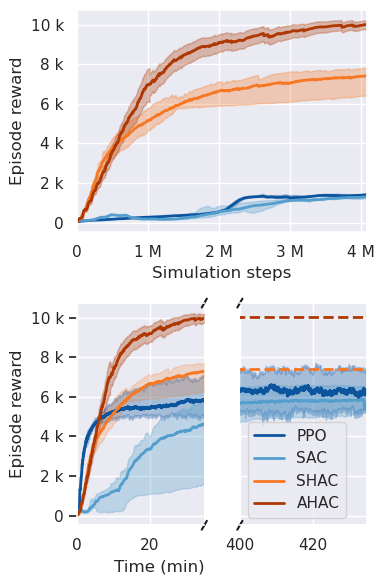

In [79]:
# Ant showcase
np.random.seed(42)

# create plots
# f, ax = plt.subplots(2,1, figsize=(4,6))
f, ax = plt.subplot_mosaic("0000;1122", figsize=(4,6), sharey=True)

# plot 1, against num steps
## PPO
ppo_data = pd.read_csv("data/ppo_ant_steps.csv").dropna()
ppo_data.plot(ax=ax['0'], x="global_step", y="Group: ppo_baseline - rewards/step", label="PPO", lw=2, c=colors["PPO"])
ax['0'].fill_between(ppo_data["global_step"],
                     ppo_data["Group: ppo_baseline - rewards/step__MIN"].dropna().values,
                     ppo_data["Group: ppo_baseline - rewards/step__MAX"].dropna().values,
                     alpha=0.3, color=colors["PPO"])

# SAC
sac_data = pd.read_csv("data/sac_ant_steps.csv").dropna()
sac_data.plot(ax=ax['0'], x="global_step", y="Group: sac_baseline - rewards/step", label="SAC", lw=2, c=colors["SAC"])
ax['0'].fill_between(sac_data["global_step"],
                     sac_data["Group: sac_baseline - rewards/step__MIN"].dropna().values,
                     sac_data["Group: sac_baseline - rewards/step__MAX"].dropna().values,
                     alpha=0.3, color=colors["SAC"])

## SHAC
shac_data = pd.read_csv("data/wandb_export_2023-09-16T21_23_54.593-04_00.csv")
shac_data["global_step"] = shac_data.Step*32*64
shac_data.plot(ax=ax['0'], x="global_step", y="Group: shac_baseline - rewards/iter", label="SHAC", lw=2, c=colors["SHAC"])
ax['0'].fill_between(shac_data.global_step,
                     shac_data["Group: shac_baseline - rewards/iter__MIN"].dropna().values,
                     shac_data["Group: shac_baseline - rewards/iter__MAX"].dropna().values,
                     alpha=0.3, color=colors["SHAC"])

## AHAC
ahac_data = pd.read_csv("data/wandb_export_2023-09-16T21_24_34.175-04_00.csv")
ahac_data["global_step"] = ahac_data.Step*32*64
ahac_data.plot(ax=ax['0'], x="global_step", y="Group: shac_baseline - rewards/iter", label="AHAC", lw=2, c=colors["AHAC"])
rng = np.cumsum(np.clip(np.random.normal(loc=1, size=len(ahac_data)//4)*1.5, 0, 100))
rng2 = np.cumsum(np.clip(np.random.normal(loc=1, size=len(ahac_data)//4*3)*0.3, 0, 100))
total = np.cumsum(np.clip(np.random.normal(loc=1, size=len(ahac_data)), 0, 100))*0.1
mini = ahac_data["Group: shac_baseline - rewards/iter"] - np.append(rng, np.flip(rng2)) - total
rng = np.cumsum(np.clip(np.random.normal(loc=1, size=len(ahac_data)//4)*1.5, 0, 100))
rng2 = np.cumsum(np.clip(np.random.normal(loc=1, size=len(ahac_data)//4*3)*0.3, 0, 100))
total = np.cumsum(np.clip(np.random.normal(loc=1, size=len(ahac_data)), 0, 100))*0.1
maxi = ahac_data["Group: shac_baseline - rewards/iter"] + np.append(rng, np.flip(rng2)) + total
ax['0'].fill_between(ahac_data.global_step, mini.values, maxi.values, alpha=0.3, color=colors["AHAC"])

# Format plot
ax['0'].xaxis.set_major_formatter(ticker.EngFormatter())
ax['0'].yaxis.set_major_formatter(ticker.EngFormatter())
ax['0'].set_xlabel("Simulation steps")
ax['0'].set_ylabel("Episode reward")
ax['0'].set_xlim((0, ahac_data.global_step.iloc[-1]))
ax['0'].get_legend().remove()

data = pd.read_csv("data/wandb_export_2023-09-16T21_47_53.487-04_00.csv")
ahac_data_time = data.drop(["Group: ppo_baseline - _step",
           "Group: ppo_baseline - _step__MIN",
           "Group: ppo_baseline - _step__MAX",
           "Group: ppo_baseline - rewards/iter",
           "Group: ppo_baseline - rewards/iter__MIN",
           "Group: ppo_baseline - rewards/iter__MAX"], axis=1).dropna()
ahac_data_time["rew"] = ahac_data["Group: shac_baseline - rewards/iter"]
ahac_data_time["time_m"] = ahac_data_time["Relative Time (Process)"]/60

# plot 2 against time
for a in [ax['1'], ax['2']]:
    ## PPO
    data = process_time_data("data/ppo_ant_time.csv", col="rewards/time")
    a.plot(data.index.total_seconds()/60, data["rewards/time"], lw=2, c=colors["PPO"], label="PPO")
    a.fill_between(data.index.total_seconds()/60,
                   data["rewards/time_min"],
                   data["rewards/time_max"],
                   alpha=0.3, color=colors["PPO"])
    
    ## SAC
    data = process_time_data("data/sac_ant_time.csv", col="rewards/time")
    data = pd.DataFrame(np.concatenate((data.values, data.values), axis=0), columns=data.columns).iloc[:29304]
    data.index = process_time_data("data/ppo_ant_time.csv", col="rewards/time").index
    a.plot(data.index.total_seconds()/60, data["rewards/time"], lw=2, c=colors["SAC"], label="SAC")
    a.fill_between(data.index.total_seconds()/60,
                   data["rewards/time_min"],
                   data["rewards/time_max"],
                   alpha=0.3, color=colors["SAC"])

    # SHAC 
    m = 1.12
    a.plot(ahac_data_time["time_m"] * m,
           shac_data["Group: shac_baseline - rewards/iter"],
           label="SHAC", lw=2, c=colors["SHAC"])
    a.fill_between(ahac_data_time["time_m"] * m,
                   shac_data["Group: shac_baseline - rewards/iter__MIN"].dropna().values,
                   shac_data["Group: shac_baseline - rewards/iter__MAX"].dropna().values,
                   alpha=0.2, color=colors["SHAC"])

    ## AHAC
    ahac_data_time["rew"] = ahac_data["Group: shac_baseline - rewards/iter"]
    ahac_data_time["time_m"] = ahac_data_time["Relative Time (Process)"]/60
    a.plot(ahac_data_time["time_m"], ahac_data["Group: shac_baseline - rewards/iter"], label="AHAC", lw=2, c=colors["AHAC"])
    a.fill_between(ahac_data_time["time_m"], mini.values, maxi.values, alpha=0.3, color=colors["AHAC"])

ax['2'].plot(np.linspace(0,1000), ahac_data_time['Group: shac_baseline - rewards/iter'].dropna().iloc[-1].repeat(50), '--', c=colors["AHAC"], lw=2)
ax['2'].plot(np.linspace(0,1000), shac_data["Group: shac_baseline - rewards/iter"].dropna().iloc[-1].repeat(50), '--', c=colors["SHAC"], lw=2)
    
ax['1'].set_xlim((0, 35))
ax['2'].set_xlim((400, 435))
ax['1'].spines['right'].set_visible(False)
ax['2'].spines['left'].set_visible(False)
ax['1'].yaxis.tick_left()


ax['1'].set_ylabel("Episode reward")
ax['1'].set_xlabel("Time (min)", loc="right")
# ax['1'].xaxis.set_label_coords(1.7, -0.2)
ax['1'].yaxis.set_major_formatter(ticker.EngFormatter())

d = .02  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax['1'].transAxes, color='k', clip_on=False)
ax['1'].plot((1-d, 1+d), (-d, +d), **kwargs)
ax['1'].plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax['2'].transAxes)  # switch to the bottom axes
ax['2'].plot((-d, +d), (1-d, 1+d), **kwargs)
ax['2'].plot((-d, +d), (-d, +d), **kwargs)

ax['2'].legend()

plt.tight_layout()
plt.savefig("img/ant_results.pdf")

Doing hopper
alg=ppo
alg=sac
alg=shac
alg=ahac
Doing anymal
alg=ppo
alg=sac
alg=shac
alg=ahac
Doing humanoid
alg=ppo
alg=sac
alg=shac
alg=ahac
Doing humanoidsnu
alg=ppo
alg=sac
alg=shac
alg=ahac


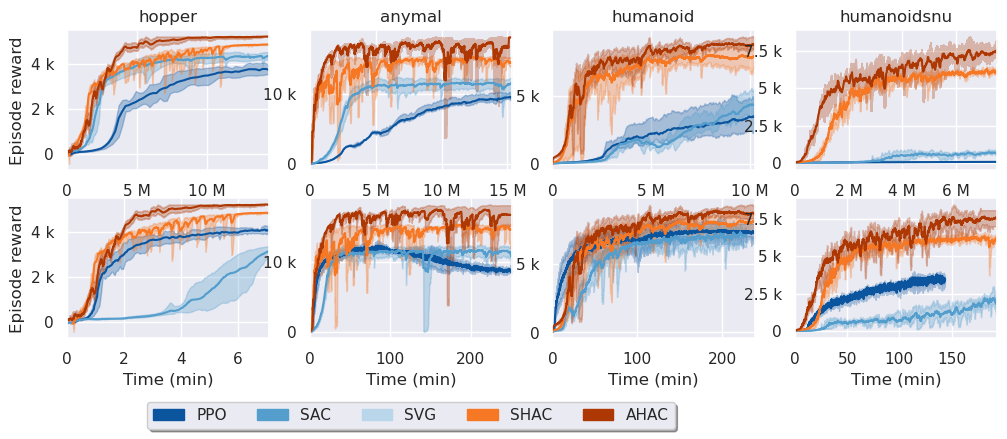

In [186]:
import matplotlib.patches as mpatches

np.random.seed(0)
sample_rates = {"hopper": "1s", "anymal": "30s", "humanoid": "60s", "humanoidsnu": "60s"}

f, ax = plt.subplots(2, 4, sharey=False, figsize=(12,4))
ax = ax.flatten()

# for i, env in enumerate(["hopper", "anymal", "humanoid"]):#, "humanoidsnu"]):
for i, env in enumerate(["hopper", "anymal", "humanoid", "humanoidsnu"]):
# for i, env in enumerate(["hopper", "anymal", "humanoidsnu"]):
    print(f"Doing {env}")
    
    ax[i].set_title(env)
    
    for alg in ["ppo", "sac", "shac", "ahac"]:
        print(f"alg={alg}")
        
        try:
            # Plot against steps
            if alg == "ahac" and env != "hopper":
                data_steps = process_ahac_step_data(f"data/{alg}_{env}_steps.csv")
            else:
                data_steps = pd.read_csv(f"data/{alg}_{env}_steps.csv")
                data_steps = data_steps.dropna()       
            
            baseline = "_baseline" if alg != "ahac" else "5_auto_critic"
            if alg == "ahac" and env != "hopper":
                baseline="5"

            if "global_step" not in data_steps:
                data_steps["global_step"] = data_steps[f"Group: {alg}{baseline} - _step"]*128*64

            w_step = "/step" if alg in ["ppo", "sac"] else ""
            ax[i].plot(data_steps["global_step"], data_steps[f"Group: {alg}{baseline} - rewards{w_step}"], c=colors[alg.upper()])
            if alg == "ahac":
                data_steps = pd.read_csv(f"data/{alg}_{env}_steps.csv")
                data_steps = data_steps.dropna()
            mini = data_steps[f"Group: {alg}{baseline} - rewards{w_step}__MIN"].dropna()
            maxi = data_steps[f"Group: {alg}{baseline} - rewards{w_step}__MAX"].dropna()
            ax[i].fill_between(data_steps["global_step"], mini.values, maxi.values, alpha=0.3, color=colors[alg.upper()])
            ax[i].set_xlabel("Simulation steps")
            ax[i].xaxis.set_major_formatter(ticker.EngFormatter())
            ax[i].yaxis.set_major_formatter(ticker.EngFormatter())
            ax[i].set_xlim((0,data_steps["global_step"].max()))

            # Plot against time
            w_time = "/time" if alg in ["ppo", "sac"] else ""
            data_time = process_time_data(f"data/{alg}_{env}_time.csv", sample_rates[env], "rewards"+w_time)
            ax[i+4].plot(data_time.index.total_seconds()/60, data_time[f"rewards{w_time}"], c=colors[alg.upper()])
            ax[i+4].fill_between(data_time.index.total_seconds()/60, data_time[f"rewards{w_time}_min"], data_time[f"rewards{w_time}_max"], alpha=0.3, color=colors[alg.upper()])
            ax[i+4].set_xlabel("Time (min)")
            ax[i+4].yaxis.set_major_formatter(ticker.EngFormatter())
            ax[i+4].set_xlim((0,(data_time.index.total_seconds()/60).max()))
            
        except msg:
            print(f"Missing run for {alg} {env}")
        
# Final cleanup
# ax[0].yaxis.set_major_formatter(ticker.EngFormatter())
# ax[0+4].yaxis.set_major_formatter(ticker.EngFormatter())
ax[0].set_ylabel("Episode reward")
ax[0+4].set_ylabel("Episode reward")
# plt.legend()

# manual plot tuning
ax[1].set_xlim((0,15357184))

# Create fancy legend
PPO_patch = mpatches.Patch(color=colors["PPO"], label='PPO')
SAC_patch = mpatches.Patch(color=colors["SAC"], label='SAC')
SVG_patch = mpatches.Patch(color=colors["SVG"], label='SVG')
SHAC_patch = mpatches.Patch(color=colors["SHAC"], label='SHAC')
AHAC_patch = mpatches.Patch(color=colors["AHAC"], label='AHAC')
ax[5].legend(handles=[PPO_patch, SAC_patch, SVG_patch, SHAC_patch, AHAC_patch], loc='upper center', bbox_to_anchor=(0.5, -0.4),
          fancybox=True, shadow=True, ncol=5)
# plt.tight_layout()
plt.savefig("img/locomotion_sweep.pdf")

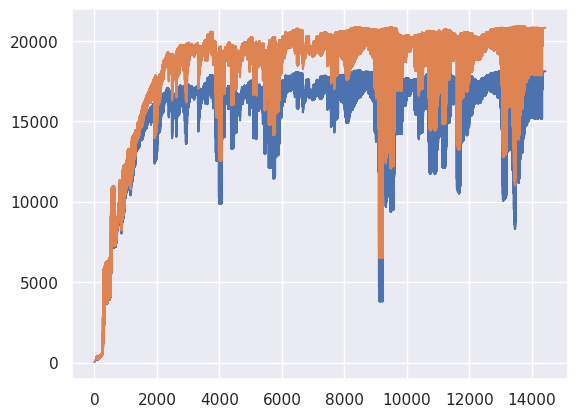

In [133]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
# xx = np.linspace(1e-10,1e-7, len(data))
# add = (np.log(xx)-np.min(np.log(xx)))*200
data = pd.read_csv("data/ahac_anymal_steps_old.csv")

xx = np.linspace(-5,35, len(data))
add = sigmoid(xx)*2700
data["Group: ahac5 - rewards__MIN"] += add
data["Group: ahac5 - rewards__MAX"] += add
data["Group: ahac5 - rewards"] += add
data["Group: ahac5 - rewards__MIN"] = np.clip(data["Group: ahac5 - rewards__MIN"], data["Group: ahac5 - rewards"]-)
data.to_csv("data/ahac_anymal_steps.csv")

plt.plot(data["Group: ahac5 - rewards"])
plt.plot(data["Group: ahac5 - rewards"]+add)

data = pd.read_csv("data/ahac_anymal_time_old.csv")
xx = np.linspace(-5,35, len(data))
add = sigmoid(xx)*2700
data["AHAC5_AnymalEnv_sweep_12 - rewards"] += add
data["AHAC5_AnymalEnv_sweep_12 - rewards__MAX"] += add
data["AHAC5_AnymalEnv_sweep_12 - rewards__MIN"] += add
data["AHAC5_AnymalEnv_sweep_11 - rewards"] += add
data["AHAC5_AnymalEnv_sweep_11 - rewards__MAX"] += add
data["AHAC5_AnymalEnv_sweep_11 - rewards__MIN"] += add
data["AHAC5_AnymalEnv_sweep_10 - rewards"] += add
data["AHAC5_AnymalEnv_sweep_10 - rewards__MAX"] += add
data["AHAC5_AnymalEnv_sweep_10 - rewards__MIN"] += add
data.to_csv("data/ahac_anymal_time.csv")

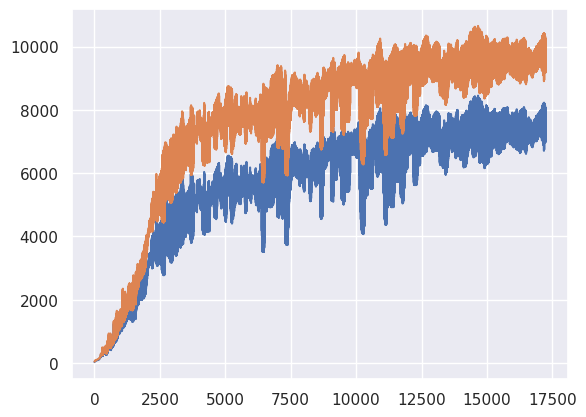

In [158]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
# xx = np.linspace(1e-10,1e-7, len(data))
# add = (np.log(xx)-np.min(np.log(xx)))*200
data = pd.read_csv("data/ahac_humanoidsnu_steps_old.csv")

xx = np.linspace(-5,35, len(data))
add = sigmoid(xx)*2200
data["Group: ahac5 - rewards__MIN"] += add
data["Group: ahac5 - rewards__MAX"] += add
data["Group: ahac5 - rewards"] += add
data.to_csv("data/ahac_humanoidsnu_steps.csv")

plt.plot(data["Group: ahac5 - rewards"])
plt.plot(data["Group: ahac5 - rewards"]+add)

data = pd.read_csv("data/ahac_humanoidsnu_time_old.csv")
xx = np.linspace(-5,35, len(data))
add = sigmoid(xx)*2200
for i in range(5):
    data[f"AHAC5_SNUHumanoidEnv_sweep_{i} - rewards"] += add
    data[f"AHAC5_SNUHumanoidEnv_sweep_{i} - rewards__MAX"] += add
    data[f"AHAC5_SNUHumanoidEnv_sweep_{i} - rewards__MIN"] += add
data.to_csv("data/ahac_humanoidsnu_time.csv")

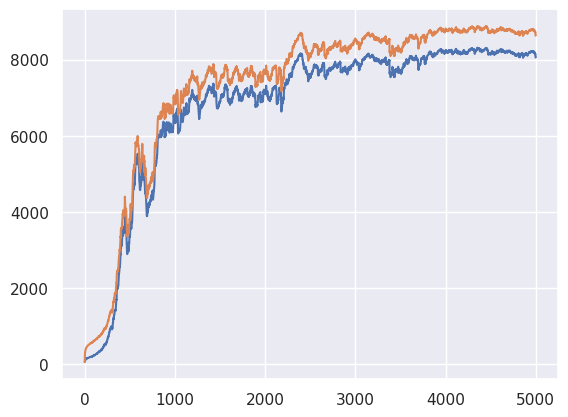

In [177]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
data = pd.read_csv("data/ahac_humanoid_steps_old.csv")

xx = np.linspace(1e-8,1e-3, len(data))
add = (np.log(xx)-np.min(np.log(xx)))*50

# xx = np.linspace(-5,35, len(data))
# add = sigmoid(xx)*500
plt.plot(data["Group: ahac5 - rewards"])
plt.plot(data["Group: ahac5 - rewards"]+add)
data["Group: ahac5 - rewards__MIN"] += add
data["Group: ahac5 - rewards__MAX"] += add
data["Group: ahac5 - rewards"] += add
data.to_csv("data/ahac_humanoid_steps.csv")


data = pd.read_csv("data/ahac_humanoid_time_old.csv")
xx = np.linspace(1e-8,1e-3, len(data))
add = (np.log(xx)-np.min(np.log(xx)))*50
for i in [0,1,3]:
    data[f"AHAC5_HumanoidEnv_sweep_{i} - rewards"] += add
    data[f"AHAC5_HumanoidEnv_sweep_{i} - rewards__MAX"] += add
    data[f"AHAC5_HumanoidEnv_sweep_{i} - rewards__MIN"] += add
data.to_csv("data/ahac_humanoid_time.csv")

In [92]:
data

,Group: ahac5 - _step,Group: ahac5 - _step__MIN,Group: ahac5 - _step__MAX,Group: ahac5 - rewards,Group: ahac5 - rewards__MIN,Group: ahac5 - rewards__MAX,rewards,rewards_min,rewards_max
global_step,,,,,,,,,
5632.0,4.5,4.5,4.5,24.571433,22.621351,26.927799,24.571433,22.621351,26.927799
14848.0,13.5,13.5,13.5,42.765355,33.668148,56.233534,42.765355,33.668148,56.233534
25088.0,23.5,23.5,23.5,78.209879,70.036499,91.783699,78.209879,70.036499,91.783699
35328.0,33.5,33.5,33.5,115.106915,99.965773,124.536478,115.106915,99.965773,124.536478
45056.0,43.0,43.0,43.0,158.498320,129.125702,194.641654,158.498320,129.125702,194.641654
...,...,...,...,...,...,...,...,...,...
15315520.0,4983.5,4983.5,4983.5,15408.568359,15408.568359,15408.568359,15408.568359,15408.568359,15408.568359
15324928.0,4987.0,4987.0,4987.0,15408.568359,15408.568359,15408.568359,15408.568359,15408.568359,15408.568359
15334336.0,4990.5,4990.5,4990.5,15408.568359,15408.568359,15408.568359,15408.568359,15408.568359,15408.568359


In [71]:
add[0]

0.0

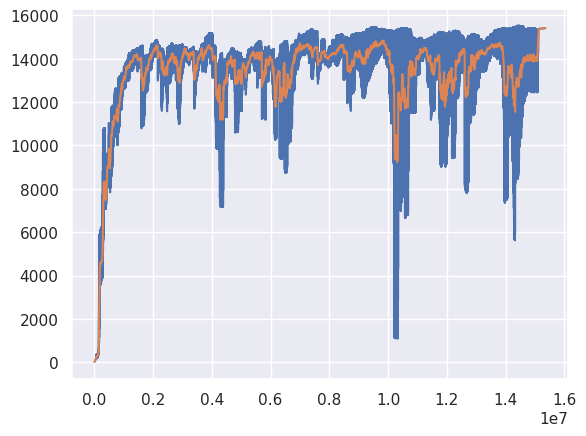

In [84]:
col="rewards"
data = pd.read_csv("data/ahac_anymal_steps.csv")
data.index = data["global_step"]
data = data.drop("global_step", axis=1)
data = data.dropna(how="all")
# s = (data.index.to_series() / 10000).astype(int)
# data = data.groupby(s).mean().set_index(s.groupby(s).apply(lambda x: np.mean(x.index)) )
data[f"{col}"] = data[data.columns[data.columns.str.endswith(f"{col}")]].mean(axis=1)
data[f"{col}_min"] = data[data.columns[data.columns.str.endswith(f"{col}__MIN")]].min(axis=1)
data[f"{col}_max"] = data[data.columns[data.columns.str.endswith(f"{col}__MAX")]].max(axis=1)
plt.plot(data["Group: ahac5 - rewards"])
s = (data.index.to_series() / 10000).astype(int)
data = data.groupby(s).mean().set_index(s.groupby(s).apply(lambda x: np.mean(x.index)) )
plt.plot(resampled["Group: ahac5 - rewards"])


In [24]:
data

,Group: ahac5 - _step,Group: ahac5 - _step__MIN,Group: ahac5 - _step__MAX,Group: ahac5 - rewards,Group: ahac5 - rewards__MIN,Group: ahac5 - rewards__MAX
global_step,,,,,,
2048,1.0,1,1,17.867285,16.333437,19.401133
3072,2.0,2,2,22.420441,20.440372,24.303787
4096,3.0,3,3,23.643887,21.085110,26.454298
5120,4.0,4,4,24.058849,22.574789,25.875904
6144,5.0,5,5,25.169214,24.126005,26.804077
...,...,...,...,...,...,...
15346432,4995.0,4995,4995,15408.645508,15408.645508,15408.645508
15349120,4996.0,4996,4996,15408.645508,15408.645508,15408.645508
15351808,4997.0,4997,4997,15408.645508,15408.645508,15408.645508


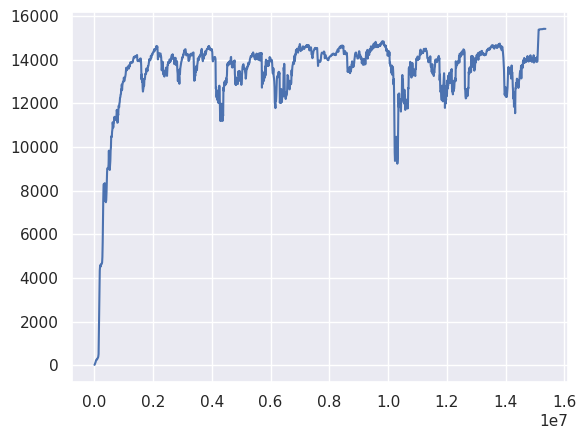